In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.model_selection import train_test_split

In [80]:
df = pd.read_csv('dirty_cafe_sales.csv')

In [81]:
df.shape

(10000, 8)

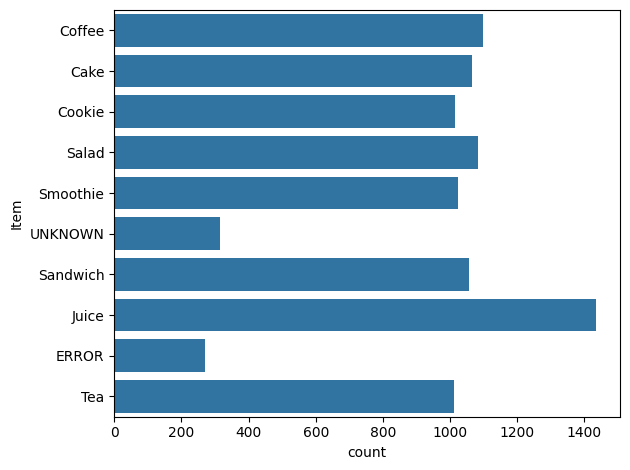

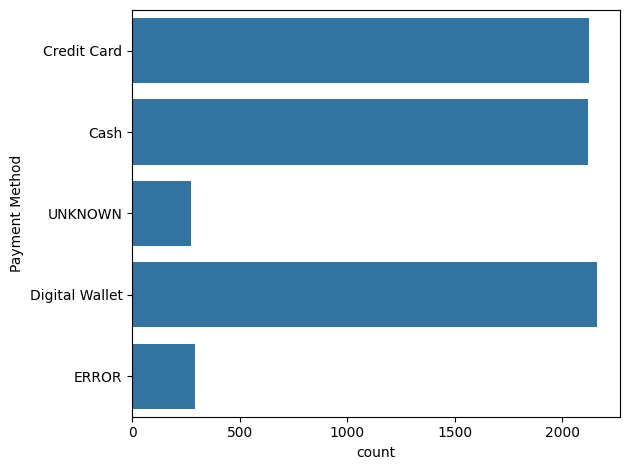

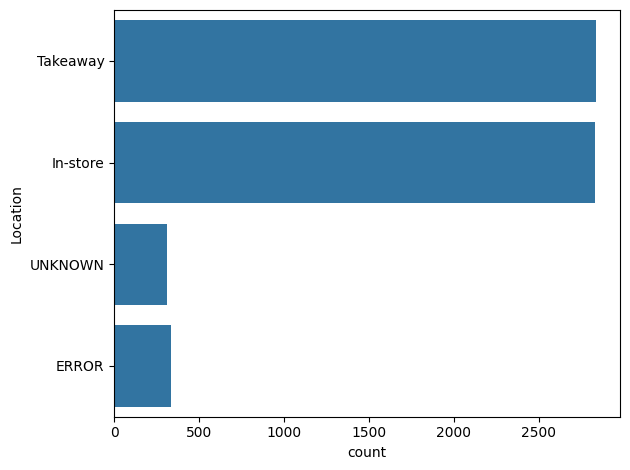

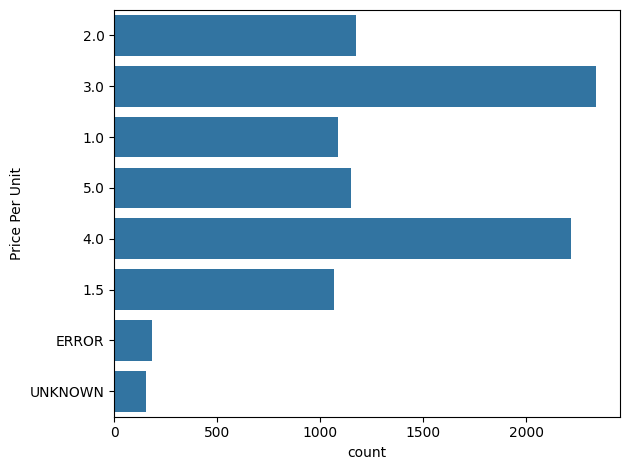

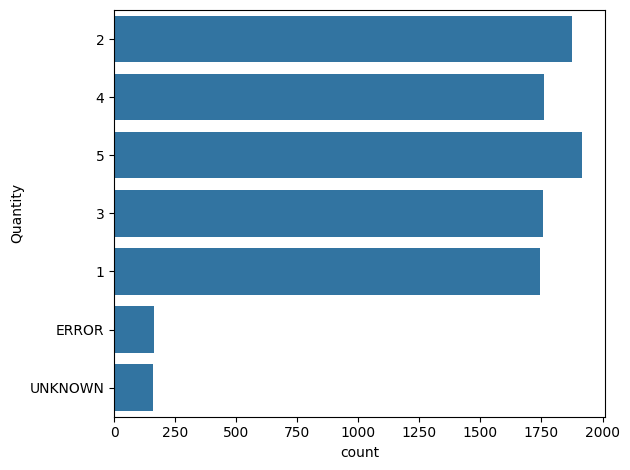

In [153]:
for i in ['Item','Payment Method','Location','Price Per Unit','Quantity']:
    plt.Figure(figsize=(8,5))
    sns.countplot(df[i])
    plt.tight_layout()
    plt.show()

In [82]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [84]:
df.isnull().mean()

Transaction ID      0.0000
Item                0.0333
Quantity            0.0138
Price Per Unit      0.0179
Total Spent         0.0173
Payment Method      0.2579
Location            0.3265
Transaction Date    0.0159
dtype: float64

In [85]:
df.isnull().sum()

Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

In [86]:
df.describe()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_1961373,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


In [ ]:
df['Transaction ID'] = df['Transaction ID'].str.strip("TXN_")

In [111]:
columns_to_drop_null_values = [x for x in df.columns if df[x].isnull().mean() < 0.05 and df[x].isnull().mean() > 0 ]

In [112]:
columns_to_drop_null_values

['Quantity', 'Price Per Unit', 'Total Spent', 'Transaction Date']

In [118]:
df.dropna(subset = columns_to_drop_null_values,inplace=True)

In [120]:
df.isnull().sum()

Transaction ID         0
Item                   0
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method      2403
Location            3055
Transaction Date       0
dtype: int64

In [121]:
print((df['Item'] == 'ERROR').sum())
print((df['Quantity'] == 'ERROR').sum())
print((df['Price Per Unit'] == 'ERROR').sum())
print((df['Total Spent'] == 'ERROR').sum())
print((df['Payment Method'] == 'ERROR').sum())
print((df['Location'] == 'ERROR').sum())
print((df['Transaction Date'] == 'ERROR').sum())

271
164
186
159
293
336
136


In [122]:
print((df['Item'] == 'UNKNOWN').sum())
print((df['Quantity'] == 'UNKNOWN').sum())
print((df['Price Per Unit'] == 'UNKNOWN').sum())
print((df['Total Spent'] == 'UNKNOWN').sum())
print((df['Payment Method'] == 'UNKNOWN').sum())
print((df['Location'] == 'UNKNOWN').sum())
print((df['Transaction Date'] == 'UNKNOWN').sum())

314
161
156
159
274
310
147
